In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from ses_network_3_0 import SESNetwork
#from extraction_works.ses_network_2_0_copy import SESNetwork
from utils import make_input, LatentSpace, get_sample_from_num_swaps, get_cos_sim_np, get_cos_sim_torch, test_network, get_ordered_weights

In [3]:
network_parameters = {}

network_parameters["hebbian_filter"] = False

network_parameters["duration_phase_A"] = 1000
network_parameters["duration_phase_B"] = 1500

network_parameters["sleep_duration_A"] = 10
network_parameters["sleep_duration_B"] = 10
network_parameters["reset_dayly"] = True

network_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "mtl", "ctx"]

network_parameters["mtl_pattern_complete_iterations"] = 10
network_parameters["mtl_dense_pattern_complete_iterations"] = 10
network_parameters["mtl_sparse_pattern_complete_iterations"] = 10
network_parameters["ctx_pattern_complete_iterations"] = 10
network_parameters["mtl_generate_pattern_complete_iterations"] = 10

network_parameters["max_semantic_charge"] = 2

network_parameters["sen_num_subregions"] = 1
network_parameters["sen_size_subregions"] = torch.tensor([100])
network_parameters["sen_sparsity"] = torch.tensor([0.2])
network_parameters["sen_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["ctx_num_subregions"] = 2
network_parameters["ctx_size_subregions"] =  torch.tensor([100, 250])
network_parameters["ctx_sparsity"] = torch.tensor([0.2, 1/25])
network_parameters["ctx_sparsity_sleep"] = torch.tensor([0.1, 1/25])

network_parameters["mtl_num_subregions"] = 2
network_parameters["mtl_size_subregions"] =  torch.tensor([100, 100])
network_parameters["mtl_sparsity"] = torch.tensor([0.2, 0.1])
network_parameters["mtl_sparsity_sleep"] = torch.tensor([0.1, 0.05])

network_parameters["mtl_dense_num_subregions"] = 1
network_parameters["mtl_dense_size_subregions"] = torch.tensor([100])
network_parameters["mtl_dense_sparsity"] = torch.tensor([0.2])
network_parameters["mtl_dense_sparsity_sleep"] = torch.tensor([0.1])

network_parameters["mtl_sparse_num_subregions"] = 1
network_parameters["mtl_sparse_size_subregions"] = torch.tensor([100])
network_parameters["mtl_sparse_sparsity"] = torch.tensor([0.1])
network_parameters["mtl_sparse_sparsity_sleep"] = torch.tensor([0.05])

network_parameters["mtl_dense_sen_projection"] = False
network_parameters["mtl_dense_sen_sparsity"] = 0.5

network_parameters["ctx_mtl_quick_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_quick"] = np.inf
network_parameters["max_post_ctx_mtl_quick"] = 1

network_parameters["ctx_mtl_sparsity"] = 0.5
network_parameters["ctx_mtl_mean"] = 0.03
network_parameters["ctx_mtl_std"] = 0.001
network_parameters["ctx_mtl_lmbda"] = 5e-4
network_parameters["ctx_mtl_size"] = 2
network_parameters["max_pre_ctx_mtl"] = np.inf
network_parameters["max_post_ctx_mtl"] = 1

network_parameters["ctx_mtl_sparse_mean"] = 0.07
network_parameters["ctx_mtl_sparse_std"] = 0.001
network_parameters["ctx_mtl_sparse_lmbda"] = 5e-4
network_parameters["max_pre_ctx_mtl_sparse"] = np.inf
network_parameters["max_post_ctx_mtl_sparse"] = 1

network_parameters["ctx_mtl_dense_sparsity"] = 0.5
network_parameters["ctx_mtl_dense_g"] = 0.01

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = 1
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = 1
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = 1
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf

network_parameters["ctx_ctx_sparsity"] = 0.05
network_parameters["ctx_ctx_g"] = 1e-4
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf

network_parameters["mtl_sparse_ctx_mean"] = 0.03
network_parameters["mtl_sparse_ctx_std"] = 0.001
network_parameters["mtl_sparse_ctx_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_ctx"] = np.inf
network_parameters["max_post_mtl_sparse_ctx"] = 1


recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_hat", "mtl_dense", "mtl_sparse", "mtl_sparse_hat", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
#recording_parameters["connections"] = ["mtl_mtl", "ctx_mtl", "ctx_ctx", "ctx_mtl_quick", "mtl_sparse_ctx"]
recording_parameters["connections"] = ["mtl_sparse_mtl_sparse"]
recording_parameters["rate_connectivity"] = 1

In [4]:
input_params = {}
input_params["num_days"] = 1500
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

'''
latent_specs["num"] = 5
latent_specs["total_sizes"] = [20, 20, 20, 20, 20]
latent_specs["act_sizes"] = [10, 10, 10, 10, 10]
latent_specs["dims"] = [2, 2, 2, 2, 2]
'''

'\nlatent_specs["num"] = 5\nlatent_specs["total_sizes"] = [20, 20, 20, 20, 20]\nlatent_specs["act_sizes"] = [10, 10, 10, 10, 10]\nlatent_specs["dims"] = [2, 2, 2, 2, 2]\n'

In [5]:
def test_network(net, input_params, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      net.sleep()
  return input, input_episodes, input_latents, net

In [6]:
#latent_specs["prob_list"] = [0.05 if i==j else 0.05/9 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/100 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/32 for i in range(32)]

#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
#latent_specs["prob_list"] = [0.1 if i==j else 0.1/4 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0 if i==j else 1/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [7]:
X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)

In [8]:
# Flatten time
days, day_length, num_latents = X_latent_AB.shape
_, num_neurons_ctx = X_ctx.shape
_, num_neurons_sparse = X_mtl_sparse.shape
_, num_neurons_dense = X_mtl_dense.shape

latents_flat = X_latent_AB.reshape(-1, num_latents).float()    # shape: (days * day_length, num_latents)
neurons_ctx_flat = X_ctx.reshape(-1, num_neurons_ctx).float()    # shape: (days * day_length, num_neurons)
neurons_sparse_flat = X_mtl_sparse.reshape(-1, num_neurons_sparse).float()    # shape: (days * day_length, num_neurons)
neurons_dense_flat = X_mtl_dense.reshape(-1, num_neurons_dense).float()    # shape: (days * day_length, num_neurons)

# Normalize (zero mean, unit variance)
latents_norm = (latents_flat - latents_flat.mean(dim=0)) / latents_flat.std(dim=0)
neurons_ctx_norm = (neurons_ctx_flat - neurons_ctx_flat.mean(dim=0)) / neurons_ctx_flat.std(dim=0)
neurons_sparse_norm = (neurons_sparse_flat - neurons_sparse_flat.mean(dim=0)) / neurons_sparse_flat.std(dim=0)
neurons_dense_norm = (neurons_dense_flat - neurons_dense_flat.mean(dim=0)) / neurons_dense_flat.std(dim=0)



# Compute correlation (selectivity): (num_neurons, num_latents)
selectivity_ctx = neurons_ctx_norm.T @ latents_norm / latents_norm.shape[0]
selectivity_sparse = neurons_sparse_norm.T @ latents_norm / latents_norm.shape[0]
selectivity_dense = neurons_dense_norm.T @ latents_norm / latents_norm.shape[0]

In [9]:
threshold = 0.8
num_neurons, num_latents = selectivity_ctx.shape

# Identify the latent with the highest selectivity per neuron
max_selectivity, max_latent_idx = selectivity_ctx.max(dim=1)

# Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

# Generate reordered indices
ordered_indices = []

# Iterate over each latent to collect selective neurons
for latent in range(num_latents):
    latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
    ordered_indices.append(latent_neurons)

# Add non-selective neurons at the end
non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
ordered_indices.append(non_selective_neurons)

# Concatenate indices into a single ordering
ordered_indices_ctx = torch.cat(ordered_indices)



threshold = 0.2
num_neurons, num_latents = selectivity_sparse.shape

# Identify the latent with the highest selectivity per neuron
max_selectivity, max_latent_idx = selectivity_sparse.max(dim=1)

# Assign neurons to latents if selectivity >= threshold, else assign -1 (non-selective)
assigned_latents = torch.where(max_selectivity >= threshold, max_latent_idx, -1)

# Generate reordered indices
ordered_indices = []

# Iterate over each latent to collect selective neurons
for latent in range(num_latents):
    latent_neurons = (assigned_latents == latent).nonzero(as_tuple=True)[0]
    ordered_indices.append(latent_neurons)

# Add non-selective neurons at the end
non_selective_neurons = (assigned_latents == -1).nonzero(as_tuple=True)[0]
ordered_indices.append(non_selective_neurons)

# Concatenate indices into a single ordering
ordered_indices_sparse = torch.cat(ordered_indices)


In [10]:
ctx_random = torch.randn(network.ctx_size)
ctx = network.pattern_complete('ctx', h_0=ctx_random, subregion_index=0, sleep=True)

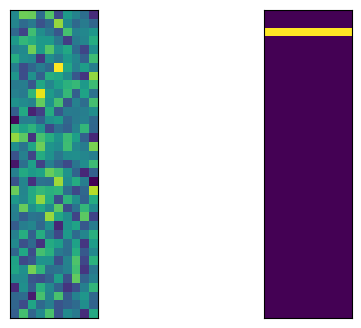

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4))  # 1 row, 3 columns

axs[0].imshow(ctx_random.reshape(-1, 10))
axs[1].imshow(ctx[ordered_indices_ctx].reshape(-1, 10))

for i, axs in enumerate(axs):
    axs.set_xticks([])
    axs.set_yticks([])

In [12]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_B][:, ordered_indices].T)

TypeError: only integer tensors of a single element can be converted to an index

In [13]:
_, order_ctx_ctx, w_ctx_ctx = get_ordered_weights(network.ctx_ctx, order_columns=True)
_, order_mtl_sparse_ctx_A, w_mtl_sparse_ctx = get_ordered_weights(network.mtl_sparse_ctx)
_, order_mtl_sparse_ctx_B, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_mtl_sparse_ctx_C, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_ctx_mtl, w_ctx_mtl = get_ordered_weights(network.ctx_mtl)

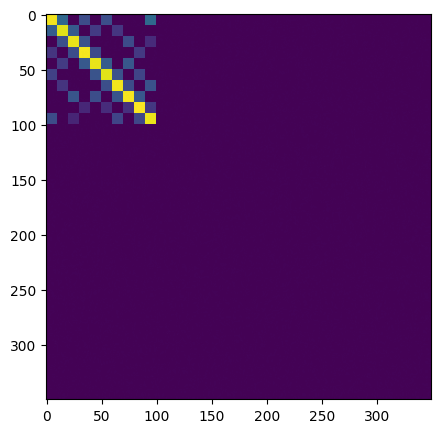

In [14]:
fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_ctx)

([<matplotlib.axis.YTick at 0x4a7323ac0>,
 [Text(0, 0, '0'),
  Text(0, 10, '10'),
  Text(0, 20, '20'),
  Text(0, 30, '30'),
  Text(0, 40, '40'),
  Text(0, 50, '50'),
  Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90')])

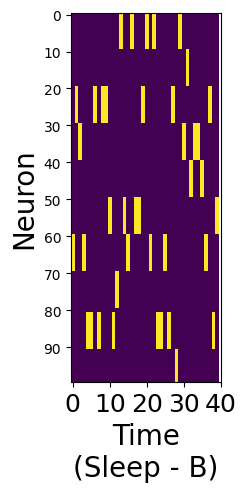

In [12]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_B][-input_params["day_length"]:][:, ordered_indices_ctx[:100]].reshape(-1, 100).T)
plt.yticks([])
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time\n(Sleep - B)", fontsize=20)
plt.yticks(np.arange(0, 100, 10))

Text(0.5, 0, 'Time\n(Sleep - B)')

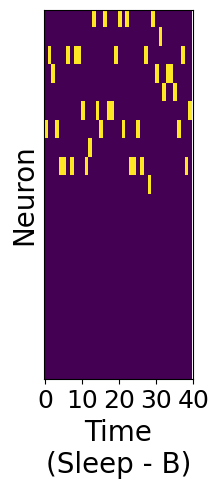

In [13]:
plt.imshow(torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.sleep_indices_B][-input_params["day_length"]:][:, ordered_indices_sparse[:100]][:, :100].reshape(-1, 100).T)
plt.yticks([])
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time\n(Sleep - B)", fontsize=20)

Text(0.5, 0, 'Time\n(Sleep - B)')

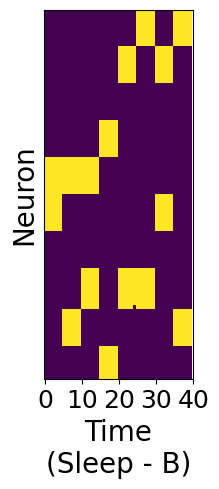

In [14]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-input_params["day_length"]:][:, ordered_indices_ctx[:100]].reshape(-1, 100).T)
plt.yticks([])
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time\n(Sleep - B)", fontsize=20)

Text(0.5, 0, 'Time\n(Sleep - B)')

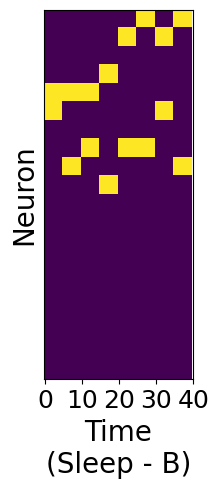

In [15]:
plt.imshow(torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-input_params["day_length"]:][:, ordered_indices_sparse[:100]].reshape(-1, 100).T)
plt.yticks([])
plt.xticks([0, 10, 20, 30, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time\n(Sleep - B)", fontsize=20)

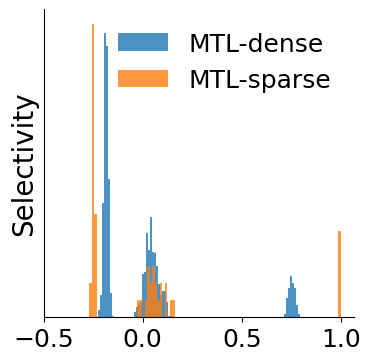

In [16]:
fig = plt.figure(figsize=(4, 4))
plt.hist(selectivity_dense.flatten(), bins=100, label="MTL-dense", alpha=0.8)
plt.hist(selectivity_sparse.flatten(), bins=100, label="MTL-sparse", alpha=0.8)
plt.ylabel('Selectivity', fontsize=20)
sns.despine()
plt.xticks([-0.5, 0, 0.5, 1], fontsize=18)
plt.yticks([])
plt.legend(fontsize=18, frameon=False)

([], [])

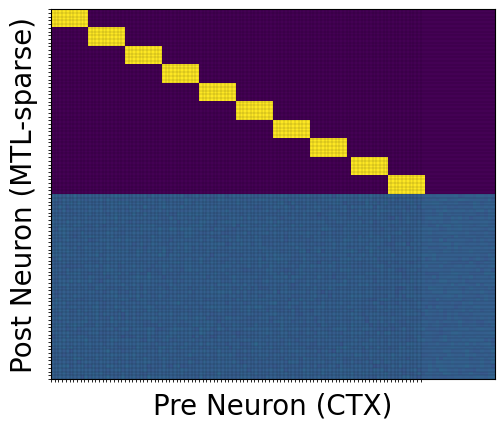

In [17]:
plt.imshow(network.mtl_sparse_ctx[ordered_indices_sparse[:110]][:, ordered_indices_ctx[:120]])
plt.ylabel("Post Neuron (MTL-sparse)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

In [18]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episdoes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [19]:
network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
input, input_episodes, input_latents, network = test_network(network, input_params, sleep=False, print_rate=50)


0
50


In [20]:
X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB

In [21]:
# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)

In [22]:
# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

In [23]:
# Create a simple linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)
    

def dual_task_cross_entropy(output, targets):
    """
    output: Tensor of shape (batch_size, 10)
    target_A: Tensor of shape (batch_size,) with values in [0, 4]
    target_B: Tensor of shape (batch_size,) with values in [0, 4]
    """
    logits_A = output[:, :5]   # First 5 neurons
    logits_B = output[:, 5:]   # Last 5 neurons

    loss_A = F.cross_entropy(logits_A, targets[:, 0])
    loss_B = F.cross_entropy(logits_B, targets[:, 1])

    return loss_A + loss_B

In [24]:
def train_model(state_dicts, train_loader, X_test, Y_test, num_trials, num_epochs):

  trials_accuracy = torch.zeros((num_trials, num_epochs, 2))
  for trial in range(num_trials):
    print(trial)
    input_size = 100
    num_classes = 10
    model = LinearClassifier(input_size, num_classes)
    model.load_state_dict(state_dicts[trial])

    optimizer = optim.SGD(model.parameters(), lr=0.005)

    eval_acc = []
    for epoch in range(num_epochs):
        #if epoch%50 == 0:
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = dual_task_cross_entropy(outputs, labels.long())
            loss.backward()
            optimizer.step()

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            predicted = torch.max(test_outputs[:, :5], 1)[1], torch.max(test_outputs[:, 5:], 1)[1]                         
            accuracy_0 = accuracy_score(Y_test[:, 0].numpy(), predicted[0].numpy())
            accuracy_1 = accuracy_score(Y_test[:, 1].numpy(), predicted[1].numpy())
            eval_acc.append((accuracy_0, accuracy_1))
    trials_accuracy[trial] = torch.tensor(eval_acc)
  return trials_accuracy

In [25]:
num_trials = 10
num_epochs = 50

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [26]:
mean_acc_dense = torch.mean(acc_mtl_dense, axis=(0, 2))
mean_acc_sparse = torch.mean(acc_mtl_sparse, axis=(0, 2))
mean_acc_latent = torch.mean(acc_latent, axis=(0, 2))


std_acc_dense =  torch.std(acc_mtl_dense, axis=(0, 2))
std_acc_sparse =  torch.std(acc_mtl_sparse, axis=(0, 2))
std_acc_latent =  torch.std(acc_latent, axis=(0, 2))

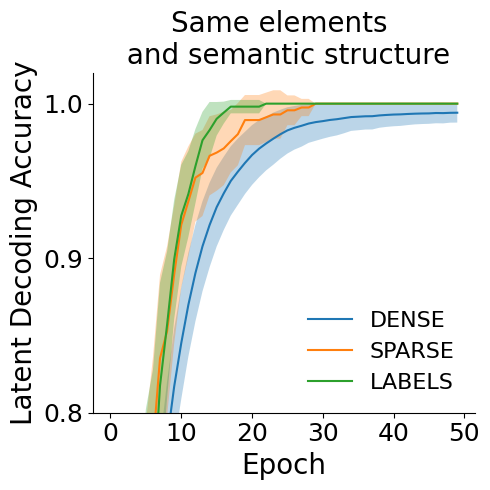

In [27]:
plt.figure(figsize=(5, 5))
plt.plot(mean_acc_dense, label="DENSE")
plt.fill_between(np.arange(num_epochs), mean_acc_dense - std_acc_dense/2, mean_acc_dense + std_acc_dense/2, alpha = 0.3)
plt.plot(mean_acc_sparse, label='SPARSE')
plt.fill_between(np.arange(num_epochs), mean_acc_sparse - std_acc_sparse/2, mean_acc_sparse + std_acc_sparse/2, alpha = 0.3)
plt.plot(mean_acc_latent, label='LABELS')
plt.fill_between(np.arange(num_epochs), mean_acc_latent - std_acc_latent/2, mean_acc_latent + std_acc_latent/2, alpha = 0.3)
plt.xticks([0, 10, 20, 30, 40, 50], fontsize=18)
plt.ylim(0.8, 1.02)
plt.yticks([0.8, 0.9, 1], fontsize=18)
#plt.yticks([0, 0.5, 1], fontsize=18)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Latent Decoding Accuracy", fontsize=20)
plt.legend(fontsize=16, frameon=False)
plt.title('Same elements \n and semantic structure', fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig("4D1.svg", transparent=True, dpi=300)

In [28]:
network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

input, input_episodes, input_latents, network = test_network(network, input_params, sleep=False, print_rate=50)

0
50


In [29]:
X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

In [33]:
num_trials = 10
num_epochs = 50

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [30]:
mean_acc_dense = torch.mean(acc_mtl_dense, axis=(0, 2))
mean_acc_sparse = torch.mean(acc_mtl_sparse, axis=(0, 2))
mean_acc_latent = torch.mean(acc_latent, axis=(0, 2))


std_acc_dense =  torch.std(acc_mtl_dense, axis=(0, 2))
std_acc_sparse =  torch.std(acc_mtl_sparse, axis=(0, 2))
std_acc_latent =  torch.std(acc_latent, axis=(0, 2))

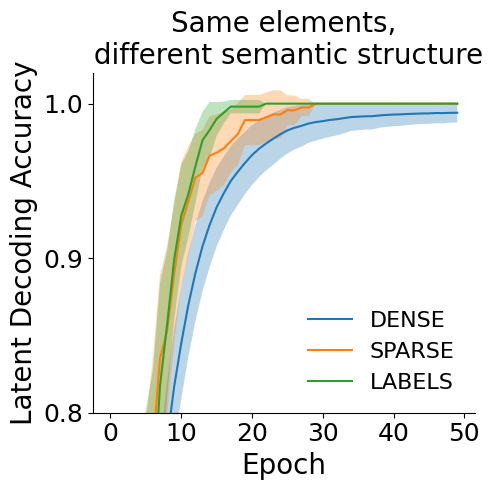

In [31]:
plt.figure(figsize=(5, 5))
plt.plot(mean_acc_dense, label="DENSE")
plt.fill_between(np.arange(num_epochs), mean_acc_dense - std_acc_dense/2, mean_acc_dense + std_acc_dense/2, alpha = 0.3)
plt.plot(mean_acc_sparse, label='SPARSE')
plt.fill_between(np.arange(num_epochs), mean_acc_sparse - std_acc_sparse/2, mean_acc_sparse + std_acc_sparse/2, alpha = 0.3)
plt.plot(mean_acc_latent, label='LABELS')
plt.fill_between(np.arange(num_epochs), mean_acc_latent - std_acc_latent/2, mean_acc_latent + std_acc_latent/2, alpha = 0.3)
plt.xticks([0, 10, 20, 30, 40, 50], fontsize=18)
plt.ylim(0.8, 1.02)
plt.yticks([0.8, 0.9, 1], fontsize=18)
#plt.yticks([0, 0.5, 1], fontsize=18)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Latent Decoding Accuracy", fontsize=20)
plt.legend(fontsize=16, frameon=False)
plt.title('Same elements,\n different semantic structure', fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig("4D1.svg", transparent=True, dpi=300)

In [32]:
def test_network_permuted(net, input_params, sleep=False, print_rate=1):
  input, input_episdoes, input_latents = make_input(**input_params)
  permutation = torch.randperm(network.sen_size)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day][:, permutation], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [33]:
network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network_permuted(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50


In [34]:
X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

In [35]:
num_trials = 10
num_epochs = 50

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [36]:
mean_acc_dense = torch.mean(acc_mtl_dense, axis=(0, 2))
mean_acc_sparse = torch.mean(acc_mtl_sparse, axis=(0, 2))
mean_acc_latent = torch.mean(acc_latent, axis=(0, 2))


std_acc_dense =  torch.std(acc_mtl_dense, axis=(0, 2))
std_acc_sparse =  torch.std(acc_mtl_sparse, axis=(0, 2))
std_acc_latent =  torch.std(acc_latent, axis=(0, 2))

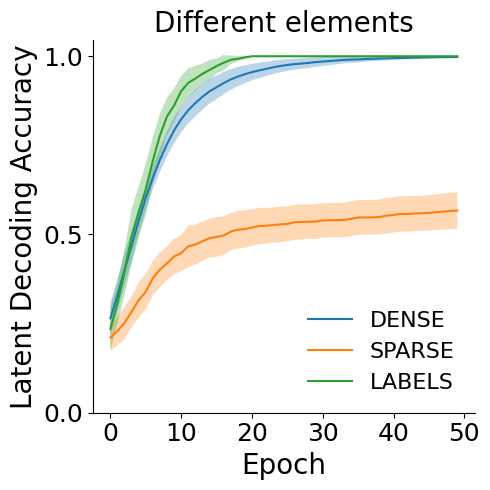

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(mean_acc_dense, label="DENSE")
plt.fill_between(np.arange(num_epochs), mean_acc_dense - std_acc_dense/2, mean_acc_dense + std_acc_dense/2, alpha = 0.3)
plt.plot(mean_acc_sparse, label='SPARSE')
plt.fill_between(np.arange(num_epochs), mean_acc_sparse - std_acc_sparse/2, mean_acc_sparse + std_acc_sparse/2, alpha = 0.3)
plt.plot(mean_acc_latent, label='LABELS')
plt.fill_between(np.arange(num_epochs), mean_acc_latent - std_acc_latent/2, mean_acc_latent + std_acc_latent/2, alpha = 0.3)
plt.xticks([0, 10, 20, 30, 40, 50], fontsize=18)
#plt.ylim(0.8, 1.02)
plt.yticks([0., 0.5, 1], fontsize=18)
#plt.yticks([0, 0.5, 1], fontsize=18)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Latent Decoding Accuracy", fontsize=20)
plt.legend(fontsize=16, frameon=False)
plt.title('Different elements', fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig("4D1.svg", transparent=True, dpi=300)

In [ ]:
mean_acc_dense = torch.mean(acc_mtl_dense, axis=(0, 2))
mean_acc_sparse = torch.mean(acc_mtl_sparse, axis=(0, 2))
mean_acc_latent = torch.mean(acc_latent, axis=(0, 2))


std_acc_dense =  torch.std(acc_mtl_dense, axis=(0, 2))
std_acc_sparse =  torch.std(acc_mtl_sparse, axis=(0, 2))
std_acc_latent =  torch.std(acc_latent, axis=(0, 2))

In [102]:
input_params = {}
input_params["num_days"] = 1500
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]


In [103]:
#latent_specs["prob_list"] = [0.05 if i==j else 0.05/9 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/100 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/32 for i in range(32)]

#latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
latent_specs["prob_list"] = [0 if i==j else 1/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [56]:
_, order_ctx_ctx, w_ctx_ctx = get_ordered_weights(network.ctx_ctx, order_columns=True)
_, order_mtl_sparse_ctx_A, w_mtl_sparse_ctx = get_ordered_weights(network.mtl_sparse_ctx)
_, order_mtl_sparse_ctx_B, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_mtl_sparse_ctx_C, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_ctx_mtl, w_ctx_mtl = get_ordered_weights(network.ctx_mtl)

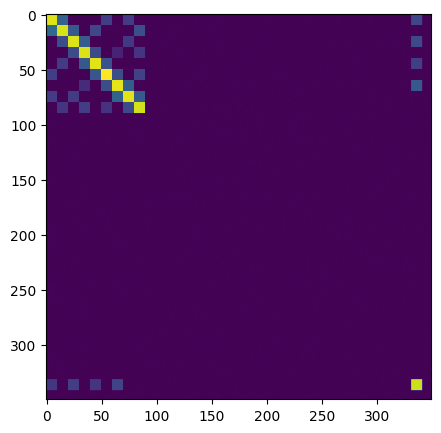

In [57]:
fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_ctx)

([], [])

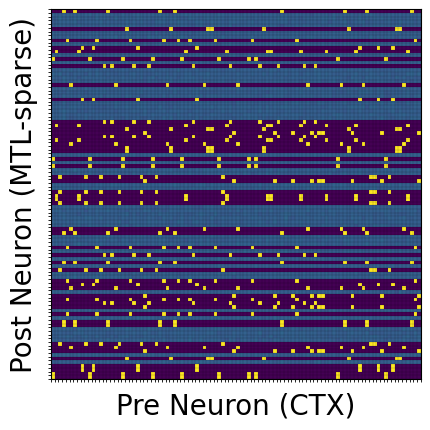

In [58]:
plt.imshow(network.mtl_sparse_ctx[ordered_indices_sparse[:100]][:, ordered_indices_ctx[:100]])
plt.ylabel("Post Neuron (MTL-sparse)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

In [105]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episdoes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [106]:
network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
input, input_episodes, input_latents, network = test_network(network, input_params, sleep=False, print_rate=50)


0
50


In [107]:
X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB

# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

In [108]:
num_trials = 10
num_epochs = 50

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


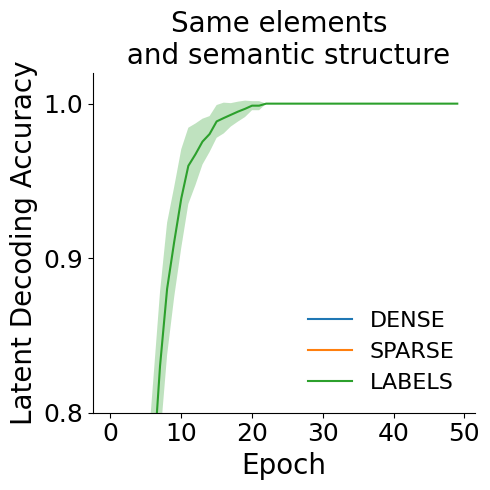

In [109]:
plt.figure(figsize=(5, 5))
plt.plot(mean_acc_dense, label="DENSE")
plt.fill_between(np.arange(num_epochs), mean_acc_dense - std_acc_dense/2, mean_acc_dense + std_acc_dense/2, alpha = 0.3)
plt.plot(mean_acc_sparse, label='SPARSE')
plt.fill_between(np.arange(num_epochs), mean_acc_sparse - std_acc_sparse/2, mean_acc_sparse + std_acc_sparse/2, alpha = 0.3)
plt.plot(mean_acc_latent, label='LABELS')
plt.fill_between(np.arange(num_epochs), mean_acc_latent - std_acc_latent/2, mean_acc_latent + std_acc_latent/2, alpha = 0.3)
plt.xticks([0, 10, 20, 30, 40, 50], fontsize=18)
plt.ylim(0.8, 1.02)
plt.yticks([0.8, 0.9, 1], fontsize=18)
#plt.yticks([0, 0.5, 1], fontsize=18)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Latent Decoding Accuracy", fontsize=20)
plt.legend(fontsize=16, frameon=False)
plt.title('Same elements \n and semantic structure', fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig("4D1.svg", transparent=True, dpi=300)

In [88]:
network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf
input_params["num_days"] = 100

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50


In [89]:
_, order_ctx_ctx, w_ctx_ctx = get_ordered_weights(network.ctx_ctx, order_columns=True)
_, order_mtl_sparse_ctx_A, w_mtl_sparse_ctx = get_ordered_weights(network.mtl_sparse_ctx)
_, order_mtl_sparse_ctx_B, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_mtl_sparse_ctx_C, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_ctx_mtl, w_ctx_mtl = get_ordered_weights(network.ctx_mtl)

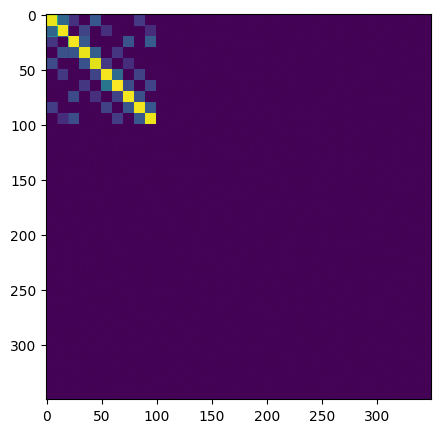

In [90]:
fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_ctx)

([], [])

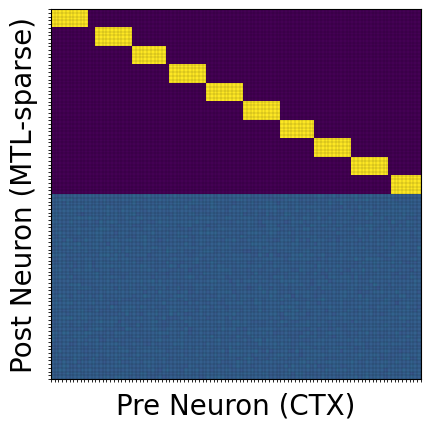

In [91]:
plt.imshow(network.mtl_sparse_ctx[ordered_indices_sparse[:100]][:, ordered_indices_ctx[:100]])
plt.ylabel("Post Neuron (MTL-sparse)", fontsize=20)
plt.xlabel("Pre Neuron (CTX)", fontsize=20)

plt.xticks(np.arange(-0.5, 100, 1), minor=True)
plt.yticks(np.arange(-0.5, 100, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

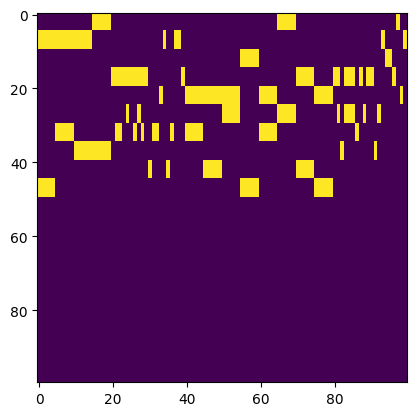

In [101]:
plt.imshow(X_mtl_sparse[-100:, ordered_indices_sparse[:100]].reshape(-1, 100).T)

In [131]:
torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.sleep_indices_B][-input_params["day_length"]:][:, ordered_indices_sparse[:100]][:, :100].reshape(-1, 100).T.shape

torch.Size([100, 0])

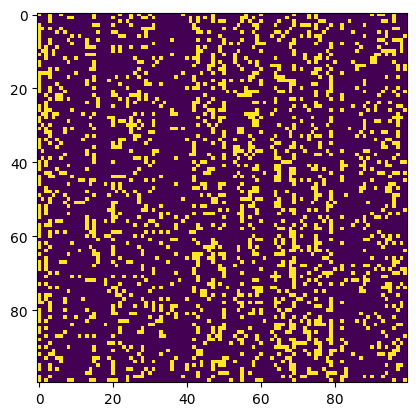

In [140]:
plt.imshow(torch.stack(network.activity_recordings["ctx"])[-100:, ordered_indices_ctx[:100]].reshape(-1, 100))

In [141]:
plt.imshow(torch.stack(network.activity_recordings["mtl"])[-100:, ordered_indices_[:100]].reshape(-1, 100))

IndexError: index 328 is out of bounds for dimension 0 with size 200

In [96]:
X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)


# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

In [97]:
num_trials = 10
num_epochs = 50

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [98]:
mean_acc_dense = torch.mean(acc_mtl_dense, axis=(0, 2))
mean_acc_sparse = torch.mean(acc_mtl_sparse, axis=(0, 2))
mean_acc_latent = torch.mean(acc_latent, axis=(0, 2))


std_acc_dense =  torch.std(acc_mtl_dense, axis=(0, 2))
std_acc_sparse =  torch.std(acc_mtl_sparse, axis=(0, 2))
std_acc_latent =  torch.std(acc_latent, axis=(0, 2))

In [99]:
mean_acc_sparse

tensor([0.1941, 0.1949, 0.1971, 0.1985, 0.1998, 0.2004, 0.2024, 0.2032, 0.2046,
        0.2044, 0.2027, 0.2023, 0.2027, 0.2029, 0.2027, 0.2031, 0.2054, 0.2055,
        0.2062, 0.2082, 0.2083, 0.2099, 0.2115, 0.2124, 0.2144, 0.2146, 0.2148,
        0.2146, 0.2149, 0.2149, 0.2154, 0.2158, 0.2169, 0.2167, 0.2179, 0.2203,
        0.2211, 0.2217, 0.2219, 0.2219, 0.2218, 0.2218, 0.2218, 0.2221, 0.2221,
        0.2234, 0.2226, 0.2228, 0.2226, 0.2237])

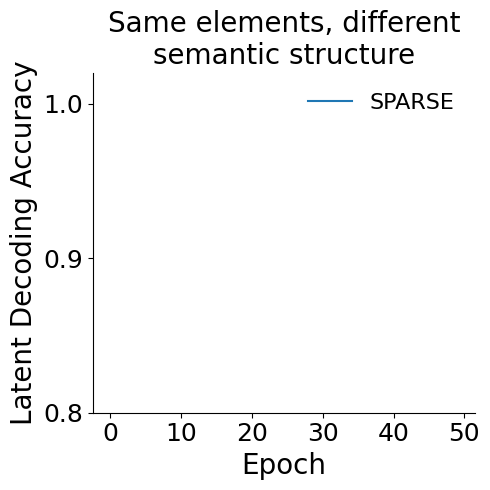

In [128]:
plt.figure(figsize=(5, 5))
#plt.plot(mean_acc_dense, label="DENSE")
#plt.fill_between(np.arange(num_epochs), mean_acc_dense - std_acc_dense/2, mean_acc_dense + std_acc_dense/2, alpha = 0.3)
plt.plot(mean_acc_sparse, label='SPARSE')
#plt.fill_between(np.arange(num_epochs), mean_acc_sparse - std_acc_sparse/2, mean_acc_sparse + std_acc_sparse/2, alpha = 0.3)
#plt.plot(mean_acc_latent, label='LABELS')
#plt.fill_between(np.arange(num_epochs), mean_acc_latent - std_acc_latent/2, mean_acc_latent + std_acc_latent/2, alpha = 0.3)
plt.xticks([0, 10, 20, 30, 40, 50], fontsize=18)
plt.ylim(0.8, 1.02)
plt.yticks([0.8, 0.9, 1], fontsize=18)
#plt.yticks([0, 0.5, 1], fontsize=18)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Latent Decoding Accuracy", fontsize=20)
plt.legend(fontsize=16, frameon=False)
plt.title('Same elements, different\nsemantic structure', fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig("4D1.svg", transparent=True, dpi=300)

In [39]:
def test_network_permuted(net, input_params, sleep=False, print_rate=1):
  input, input_episdoes, input_latents = make_input(**input_params)
  permutation = torch.randperm(network.sen_size)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day][:, permutation], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [40]:
network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network_permuted(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50


In [41]:
X_mtl_dense = torch.tensor(np.array(network.activity_recordings["mtl_dense"][-input_params["num_days"]*input_params["day_length"]:]))
X_mtl_sparse =  torch.tensor(np.array(network.activity_recordings["mtl_sparse"][-input_params["num_days"]*input_params["day_length"]:]))

X_latent_A = torch.repeat_interleave(F.one_hot(input_latents[:, :, 0].long(), num_classes=latent_specs["dims"][0]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_B = torch.repeat_interleave(F.one_hot(input_latents[:, :, 1].long(), num_classes=latent_specs["dims"][1]), dim=2, repeats=5).flatten(start_dim=0, end_dim=1)
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=1)
X_latent = torch.zeros((X_latent_AB.shape[0], 100))
X_latent[:X_latent_AB.shape[0], :X_latent_AB.shape[1]] = X_latent_AB


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)


# Split the data into training and testing sets
X_mtl_dense_train, X_mtl_dense_test, Y_train, Y_test = train_test_split(X_mtl_dense, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_mtl_sparse_train, X_mtl_sparse_test, Y_train, Y_test = train_test_split(X_mtl_sparse, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)
X_latent_train, X_latent_test, Y_train, Y_test = train_test_split(X_latent, input_latents.flatten(start_dim=0, end_dim=1), test_size=0.2, random_state=42)


# Create DataLoader for training set
train_dataset_mtl_dense = TensorDataset(X_mtl_dense_train, Y_train)
train_loader_mtl_dense = DataLoader(train_dataset_mtl_dense, batch_size=32, shuffle=True)

train_dataset_mtl_sparse = TensorDataset(X_mtl_sparse_train, Y_train)
train_loader_mtl_sparse = DataLoader(train_dataset_mtl_sparse, batch_size=32, shuffle=True)


train_dataset_latent = TensorDataset(X_latent_train, Y_train)
train_loader_latent = DataLoader(train_dataset_latent, batch_size=32, shuffle=True)

In [42]:
num_trials = 10
num_epochs = 50

input_size = 100
num_classes = 10
state_dicts = [deepcopy(LinearClassifier(input_size, num_classes).state_dict()) for trial in range(num_trials)]


acc_mtl_dense = train_model(state_dicts, train_loader_mtl_dense,  X_mtl_dense_test, Y_test, num_trials, num_epochs)
acc_mtl_sparse = train_model(state_dicts, train_loader_mtl_sparse,  X_mtl_sparse_test, Y_test, num_trials, num_epochs)
acc_latent = train_model(state_dicts, train_loader_latent, X_latent_test, Y_test, num_trials, num_epochs)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [43]:
mean_acc_dense = torch.mean(acc_mtl_dense, axis=(0, 2))
mean_acc_sparse = torch.mean(acc_mtl_sparse, axis=(0, 2))
mean_acc_latent = torch.mean(acc_latent, axis=(0, 2))


std_acc_dense =  torch.std(acc_mtl_dense, axis=(0, 2))
std_acc_sparse =  torch.std(acc_mtl_sparse, axis=(0, 2))
std_acc_latent =  torch.std(acc_latent, axis=(0, 2))

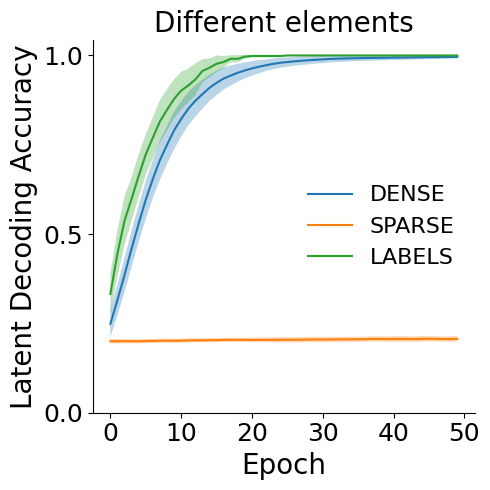

In [44]:
plt.figure(figsize=(5, 5))
plt.plot(mean_acc_dense, label="DENSE")
plt.fill_between(np.arange(num_epochs), mean_acc_dense - std_acc_dense/2, mean_acc_dense + std_acc_dense/2, alpha = 0.3)
plt.plot(mean_acc_sparse, label='SPARSE')
plt.fill_between(np.arange(num_epochs), mean_acc_sparse - std_acc_sparse/2, mean_acc_sparse + std_acc_sparse/2, alpha = 0.3)
plt.plot(mean_acc_latent, label='LABELS')
plt.fill_between(np.arange(num_epochs), mean_acc_latent - std_acc_latent/2, mean_acc_latent + std_acc_latent/2, alpha = 0.3)
plt.xticks([0, 10, 20, 30, 40, 50], fontsize=18)
#plt.ylim(0.8, 1.02)
plt.yticks([0., 0.5, 1], fontsize=18)
#plt.yticks([0, 0.5, 1], fontsize=18)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Latent Decoding Accuracy", fontsize=20)
plt.legend(fontsize=16, frameon=False)
plt.title('Different elements', fontsize=20)
sns.despine()
plt.tight_layout()
plt.savefig("4D1.svg", transparent=True, dpi=300)